# 实战 Kaggle 比赛：预测房价
实现几个函数来方便下载数据

In [103]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

# 1 Read data

In [104]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))
path = "../data/california-house-prices/"
train_data = pd.read_csv(path+'train.csv')
test_data = pd.read_csv(path+'test.csv')

print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [105]:
#前四个和最后两个特征，以及相应标签
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]
train_data.loc[:,'Sold Price'].isna().sum()

0

In [106]:
test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]
test_data.columns

Index(['Id', 'Address', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling',
       'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip', 'State'],
      dtype='object')

# 2 数据清洗
在每个样本中，第一个特征是ID， 我们将其从数据集中删除
只提取特征，train_data的最后一列是label

In [107]:
all_features = pd.concat((train_data.iloc[:, 3:], test_data.iloc[:, 2:]))


In [108]:

from math import nan


non_numerical_features = all_features.loc[:,['Type','State','Cooling features','Heating features','Last Sold Price','Last Sold On']]

# 处理last sold price na的地方使用sold price 来填充
price = train_data.loc[:,['Last Sold Price','Sold Price']]
LastSP = price['Last Sold Price'].fillna(price['Sold Price'])
#处理Last Sold On
#转化为datetime,并提取年份
#将na的年份处理为2021
LastSoldOn = pd.to_datetime(non_numerical_features['Last Sold On']).dt.year
LastSoldOn = LastSoldOn.fillna(2021.)

#处理Cooling 和 heating features
CHfeatures = non_numerical_features.loc[:,['Heating features','Cooling features']]

#把na填成各自的na
CHfeatures.loc[CHfeatures['Heating features'] == 'None','CoFe'] = "HNone"
CHfeatures.loc[CHfeatures['Cooling features'] == 'None','HeFe'] = "CNone"
CHfeatures.loc[:,'HCentral'] = CHfeatures['Heating features'].str.contains('Central')
CHfeatures.loc[:,'HForced'] = CHfeatures['Heating features'].str.contains('Forced')
CHfeatures.loc[:,'Hna'] = CHfeatures['Heating features'].fillna('Hna')
CHfeatures.loc[CHfeatures['HCentral'] == True,'HeFe'] = "HCentral"
CHfeatures.loc[CHfeatures['HForced'] == True,'HeFe'] = "HForced"
CHfeatures.loc[CHfeatures['Hna'] == 'Hna','HeFe'] = "Hna"
CHfeatures.loc[:,'Heating'] = CHfeatures['HeFe'].fillna('OtherHeating')
######################################################################################
CHfeatures.loc[:,'CCentral'] = CHfeatures['Cooling features'].str.contains('Central')
CHfeatures.loc[:,'Cna'] = CHfeatures['Cooling features'].fillna('Cna')
CHfeatures.loc[CHfeatures['CCentral'] == True,'CoFe'] = "CCentral"
CHfeatures.loc[CHfeatures['Cna'] == 'Cna','HeFe'] = "Cna"
CHfeatures.loc[:,'Cooling'] = CHfeatures['HeFe'].fillna('OtherCooling')

# CHfeatures
CHfeatures = CHfeatures.loc[:,['Heating','Cooling']]

non_numerical_features.head()
#处理Type
non_numerical_features.loc[ non_numerical_features['Type'] != ('Condo' and 'SingleFamily'),'type'] = 'TypeOthers'
non_numerical_features.loc[ non_numerical_features['Type'] == 'Condo','type'] = 'Condo'
non_numerical_features.loc[ non_numerical_features['Type'] == 'SingleFamily','type'] = 'SingleFamily'
non_numerical_features = non_numerical_features.loc[:,['State','type']]

#拼接上CHfeatures
# non_numerical_features = pd.concat((CHfeatures.iloc[:,:],non_numerical_features.iloc[:,:]))
non_numerical_features = pd.concat((non_numerical_features,CHfeatures),axis=1)
non_numerical_features

,State,type,Heating,Cooling
0,CA,SingleFamily,HForced,HForced
1,CA,SingleFamily,OtherHeating,OtherCooling
2,CA,SingleFamily,HForced,Cna
3,CA,SingleFamily,HCentral,HCentral
4,CA,TypeOthers,Hna,Cna
...,...,...,...,...
31621,CA,SingleFamily,OtherHeating,OtherCooling
31622,CA,SingleFamily,HForced,HForced
31623,CA,TypeOthers,Hna,Cna
31624,CA,TypeOthers,HForced,HForced


In [109]:
# all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

#将所有缺失的值替换为相应特征的平均值。 通过将特征重新缩放到零均值和单位方差来标准化数据

# #获取数值型value的索引
# numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# # 类似正态 ---> 标准正态
# #这里把training data 的特征和testing data的特征放在一起求的均值
# all_features[numeric_features] = all_features[numeric_features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# #na 填 0
# all_features[numeric_features] = all_features[numeric_features].fillna(0)

# #处理离散值（如字符串） 我们用一次独热编码(one-hot encode)替换它们
# all_features = pd.get_dummies(all_features, dummy_na=True)
#增加Last Sold on 和 更新后的Last Sold Price
all_features.loc[:,'Last Sold on'] = LastSoldOn
all_features.loc[:,'Last Sold Price'] = LastSP
#获取数值型value的索引
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

## #处理离散值（如字符串） 我们用一次独热编码(one-hot encode)替换它们
non_numerical_features = pd.get_dummies(non_numerical_features, dummy_na=True)


#最先只用有数字的特征
numeric_features = all_features[numeric_features].fillna(0)
numeric_features = numeric_features.iloc[:,:].apply(
    lambda x: (x - x.mean()) / (x.std()))

# # features = pd.concat((numeric_features.iloc[:, :], numeric_features.iloc[:, :]))
# # features.shape
numeric_features
features = pd.concat((numeric_features,non_numerical_features),axis=1)
# features = numeric_features
features



,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,...,Heating_Hna,Heating_OtherHeating,Heating_nan,Cooling_CNone,Cooling_Cna,Cooling_HCentral,Cooling_HForced,Cooling_Hna,Cooling_OtherCooling,Cooling_nan
0,0.165326,-0.015570,-1.749010,-1.514197,-0.006389,-0.134057,-0.122294,0.724912,-0.295420,-1.126669,...,0,0,0,0,0,0,1,0,0,0
1,0.034812,-0.015330,-0.178762,0.209546,-0.005001,-0.060504,-0.048406,-0.784763,-0.104354,-0.458459,...,0,1,0,0,0,0,0,0,1,0
2,0.131939,-0.015026,0.606362,-0.652325,-0.004554,-0.134057,-0.122294,-1.917018,-0.486486,-1.126669,...,0,0,0,0,1,0,0,0,0,0
3,0.098552,-0.015570,0.606362,1.071417,-0.002227,-0.134057,-0.122294,1.479749,-0.390953,1.212066,...,0,0,0,0,0,1,0,0,0,0
4,-5.811014,-0.015570,-1.749010,-1.514197,-0.006390,-0.134057,-0.122294,0.347493,3.573667,0.543856,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31621,0.317087,-0.015570,2.961735,-1.514197,0.002022,-0.134057,0.099371,-0.029925,2.140672,1.212066,...,0,1,0,0,0,0,0,0,1,0
31622,0.168362,-0.015474,-0.178762,-0.652325,-0.004806,0.013049,-0.048406,-0.784763,-0.104354,0.877961,...,0,0,0,0,0,0,1,0,0,0
31623,-5.811014,-0.015570,-1.749010,-1.514197,-0.006390,-0.134057,-0.122294,1.102331,0.755443,-0.124354,...,1,0,0,0,1,0,0,0,0,0
31624,0.210855,-0.015570,0.606362,0.209546,-0.004114,0.013049,0.025483,0.724912,-0.008821,0.209751,...,0,0,0,0,0,0,1,0,0,0


In [110]:
#从pandas格式中提取NumPy格式，并将其转换为张量表示
## 训练样本数，numpy默认是float64
# n_train = train_data.shape[0]
# train_features = torch.tensor(all_features[:n_train].values,
#                               dtype=torch.float32)
# test_features = torch.tensor(all_features[n_train:].values,
#                              dtype=torch.float32)
# train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
#                             dtype=torch.float32)
# n_train = train_data.shape[0]
# train_features = torch.tensor(features[:n_train].values,
#                               dtype=torch.float32)
# test_features = torch.tensor(features.iloc[n_train:].values,
#                              dtype=torch.float32)
# train_labels = torch.tensor(train_data.iloc[:,2].values.reshape(-1, 1),
#                             dtype=torch.float32)

#使用GPU来加速
def try_gpu(i=0):  
    """如果存在，则返回gpu(i)，否则返回cpu()。"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

device = try_gpu()

n_train = train_data.shape[0]
train_features = torch.tensor(features[:n_train].values,
                              dtype=torch.float32).to(device)
test_features = torch.tensor(features.iloc[n_train:].values,
                             dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data.iloc[:,2].values.reshape(-1, 1),
                            dtype=torch.float32).to(device)


# 3 Models


In [111]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

# def get_net():
#     net = nn.Sequential(nn.Linear(in_features, 1024),
#                         nn.ReLU(),
#                         nn.Dropout(0.5),
#                         nn.Linear(1024,512),
#                         nn.ReLU(),
#                         nn.Dropout(0.3),
#                         nn.Linear(512,256),
#                         nn.ReLU(),
#                         nn.Dropout(0.2),
#                         nn.Linear(256,1)
#     )
#     return net
# net = nn.Sequential(nn.Linear(in_features, 1024),
#                         nn.ReLU(),
#                         nn.Dropout(0.9),
#                         nn.Linear(1024,512),
#                         nn.ReLU(),
#                         nn.Dropout(0.5),
#                         nn.Linear(512,256),
#                         nn.ReLU(),
#                         nn.Dropout(0.5),
#                         nn.Linear(256,1)
#     )
net = nn.Sequential(nn.Linear(in_features, 256),
                        nn.ReLU(),
                        # nn.Dropout(0.3),
                        nn.Linear(256,256),
                        nn.ReLU(),
                        # nn.Dropout(0.2),
                        nn.Linear(256,128),
                        nn.ReLU(),
                        # nn.Dropout(0.5),
                        # nn.Linear(128,128),
                        nn.ReLU(),
                        nn.Linear(128,1)
    )


net.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight,gain=1)

net.apply(init_weights);

In [112]:
#我们更关心相对误差(y−y_hat)/y， 解决这个问题的一种方法是用价格预测的对数(log)来衡量差异
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

# 4 Train
采用Adam，对lr没有那么敏感

In [113]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [114]:
#K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        #第一次为空，记下来
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            #在dim=0，连接X_train
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

# 5 K-fold Training

In [115]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size,net):
    #用来记录train和validate的损失
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        # net = get_net()
        #传入的是一个元组
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        #累加append的最后一个元素
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    #返回avg_loss
    return train_l_sum / k, valid_l_sum / k

In [116]:
torch.cuda.current_device()

0

fold 1, train log rmse 0.237599, valid log rmse 0.229652
fold 2, train log rmse 0.231407, valid log rmse 0.217229
fold 3, train log rmse 0.230910, valid log rmse 0.218159
fold 4, train log rmse 0.231436, valid log rmse 0.213425
fold 5, train log rmse 0.232058, valid log rmse 0.226521
fold 6, train log rmse 0.215441, valid log rmse 0.217832
fold 7, train log rmse 0.210863, valid log rmse 0.227370
fold 8, train log rmse 0.214275, valid log rmse 0.224855
fold 9, train log rmse 0.210867, valid log rmse 0.229896
fold 10, train log rmse 0.204359, valid log rmse 0.223903
10-折验证: 平均训练log rmse: 0.221922, 平均验证log rmse: 0.222884


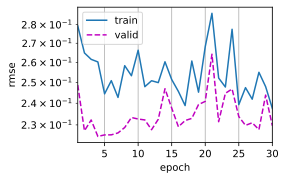

In [124]:
k, num_epochs, lr, weight_decay, batch_size = 10,30, 0.0007,0.04, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size,net)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 5 predict

train log rmse 0.293220


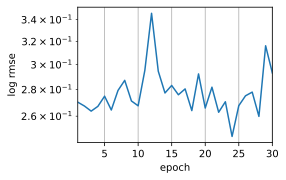

In [123]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size,net):

    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # preds = net(test_features).detach().numpy()
    preds = net(test_features)
    preds = preds.to('cpu')
    preds = preds.detach().numpy()
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)



train_and_pred(train_features, test_features, train_labels, test_data,num_epochs, lr, weight_decay, batch_size,net)